# Detailed analysis for version 0.9.27 on Intel i7-12700

Copyright 2022 https://www.math-crypto.com -- GNU General Public License

**New compared to v0.9.26**

1. Compilation procedure:
- Options where specified in Cargo.toml (as an overwritten production profile).
- We can reliably use lto=off, thin, or fat.
- Added opt-level=2 or 3 as option.
- Code-units option is now 1 or 16.
- No more production or release profile, since we have modified our own profile.

2. Objective and scores:
- Extra score: signing extrinsic.

3. Notebook analysis:
- Some util functions are moved to ``mathcrypto.py``
- Computing Pareto front (and points close it) is done by code.

In [1]:
import math
import random
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib 

from mathcrypto import * # own utils function
from paretoset import paretoset # new package

matplotlib.rc('xtick', labelsize=12) 
matplotlib.rc('ytick', labelsize=12)
plt.rcParams.update({'font.size': 16})

## Read parsed benchmark data. Clean up a bit.

In [2]:
def load_clean_benchmark(path, extrinsic=False):
    df = pd.read_feather(path)
    df['arch'] = df['arch'].fillna('none')
    df['host'] = df['host'].astype('category')
    df['arch'] = df['arch'].astype('category')
    df['ver'] = df['ver'].astype('category')
    # df['profile'] = df['profile'].astype('category') # no longer used
    df['codegen-units'] = df['codegen-units'].astype('int') # 1 or 16
    df['lto'] = df['lto'].astype('category') # off, thin, fat
    df['nb_run'] = df['nb_run'].astype('int')
    df['opt-level'] = df['opt-level'].astype('int')  # 2 or 3
    if not extrinsic:
        df['SR25519-Verify'] = df['SR25519-Verify']*1000 # same as in benchmark palette
    return df

In [3]:
df = load_clean_benchmark("processed/todo/0.9.27_i7-12700_2022-Aug-08_13h11.feather", extrinsic=False)
# Check for highest CPU percentage (TODO remove outliers if any)
max(df.loc[:,"cpu"])

0.4

In [4]:
df_ex = load_clean_benchmark("processed/todo/extrinsic_0.9.27_work-pc_2022-Aug-08_13h11.feather", extrinsic=True)
df_ex = df_ex.rename(columns={'med': 'Extr-Sign'})
max(df_ex.loc[:,"cpu"])

0.2

## Boxplot of all scores

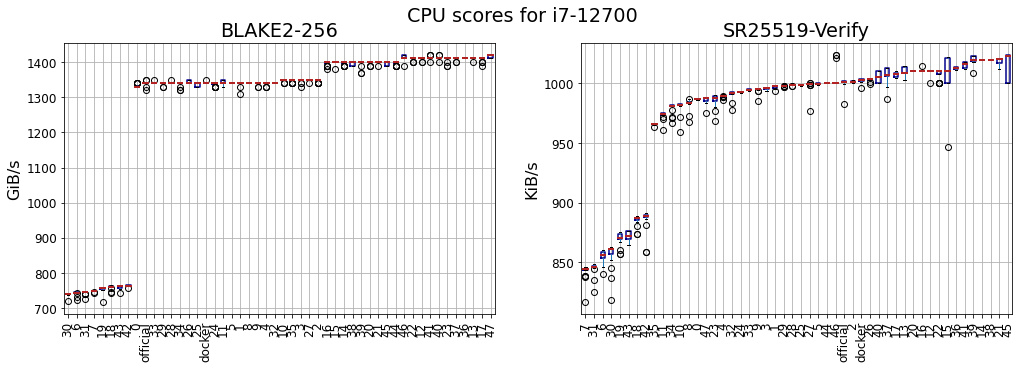

In [5]:
fig, ax = plt.subplots(1,2, figsize=(17, 5))
fig.suptitle("CPU scores for i7-12700")
boxplot_sorted(df, by="nb_build", column="BLAKE2-256", ax=ax[0])
ax[0].set_title('BLAKE2-256')
ax[0].set_ylabel('GiB/s')
boxplot_sorted(df, by="nb_build", column="SR25519-Verify", ax=ax[1])
ax[1].set_title('SR25519-Verify')
ax[1].set_ylabel('KiB/s')
fig.savefig('images/v0.9.27/scores_cpu_i7_12700.svg', bbox_inches='tight')

New objective: signing extrinsic. Smaller values are better!

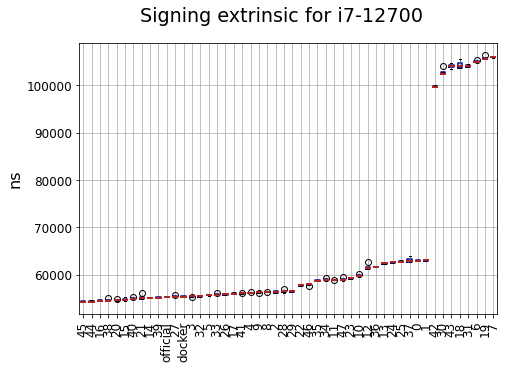

In [6]:
fig, ax = plt.subplots(1, figsize=(7.5, 5))
fig.suptitle("Signing extrinsic for i7-12700")
boxplot_sorted(df_ex, by="nb_build", column="Extr-Sign", ax=ax)
ax.set_ylabel('ns')
fig.savefig('images/v0.9.27/extr_sign_i7_12700.svg', bbox_inches='tight')

We clearly see a few **bad builds**. Let's label them...

In [7]:
bad_builds = ["30", "6", "31", "7", "19", "18", "43", "42"]

For completeness, also disk and memory scores. 

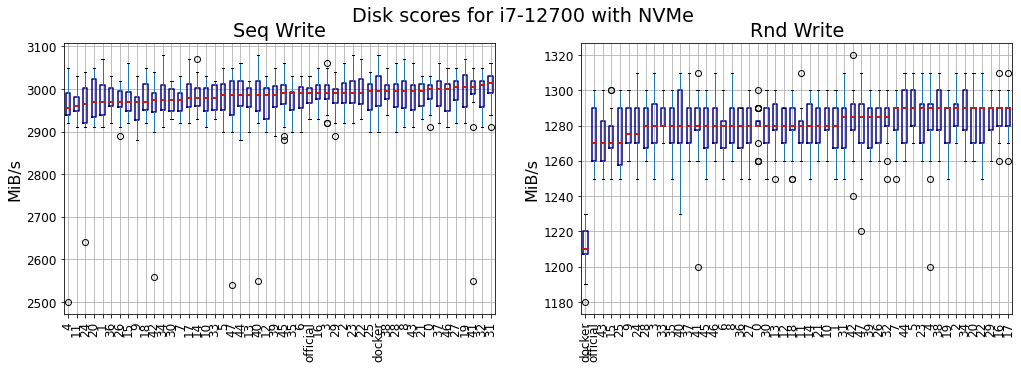

In [8]:
fig, ax = plt.subplots(1,2, figsize=(17, 5))
fig.suptitle("Disk scores for i7-12700 with NVMe")
boxplot_sorted(df, by="nb_build", column="Seq_Write", ax=ax[0])
ax[0].set_title('Seq Write')
ax[0].set_ylabel('MiB/s')
boxplot_sorted(df, by="nb_build", column="Rnd_Write", ax=ax[1])
ax[1].set_title('Rnd Write')
ax[1].set_ylabel('MiB/s')
fig.savefig('images/v0.9.27/scores_disk_i7_12700.svg', bbox_inches='tight')

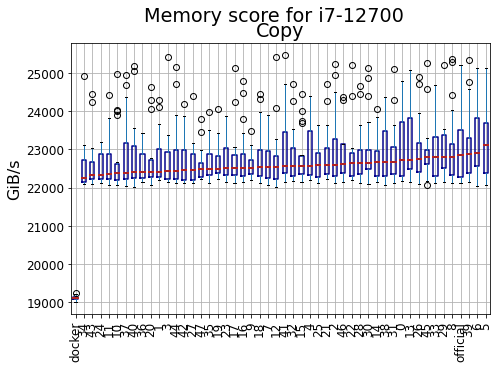

In [9]:
fig, ax = plt.subplots(1, figsize=(7.5, 5))
fig.suptitle("Memory score for i7-12700")
boxplot_sorted(df, by="nb_build", column="Copy", ax=ax)
ax.set_title('Copy')
ax.set_ylabel('GiB/s')
fig.savefig('images/v0.9.27/scores_mem_i7_12700.svg', bbox_inches='tight')

**Same conclusions** as for v0.9.26:
- Optimization has little impact on disk and memory scores (except for docker)
- Docker is still penalized here for copy and rnd write.
- Optimizing has a potential big influence on CPU scores.

**New information**:
- There are 8 builds (30, 6, 31, 7, 19, 18, 43, 42) that have very bad CPU scores.

## Table of build options

In [10]:
cat_cols = ['nb_build', 'arch', 'toolchain', 'codegen-units', 'lto', 'opt-level']
build_table = df[cat_cols].set_index('nb_build').sort_index().drop_duplicates()
# print( build_table.to_markdown() ) # for website

**What are the optimization options of the bad builds?**

In [11]:
build_table[build_table.index.isin(bad_builds)]

,arch,toolchain,codegen-units,lto,opt-level
nb_build,,,,,
18,alderlake,stable,16,off,2
19,alderlake,stable,16,off,3
30,none,nightly,16,off,2
31,none,nightly,16,off,3
42,alderlake,nightly,16,off,2
43,alderlake,nightly,16,off,3
6,none,stable,16,off,2
7,none,stable,16,off,3


Maybe surprisingly, it is not simply ``opt-level = 2``. It seems that ``codegen-units=16`` and ``lto=off`` is the reason, regardless of ``opt-level``.

## Find winning build options (close to Pareto efficient).

We only look at CPU scores and the signing extrinsic. Since it will be usefull later, we enrich the data set with the statistical errors of the mean and the mean. For simplicity, we assume normality (although not really correct here). In that case, the error the median is 1.25 x error on the mean.

In [12]:
def calc_stats(df, score):
    stats = df[["nb_build", score]].groupby("nb_build")[score].agg(['median', 'mean', 'sem'])
    stats['± mean'] = 1.96 * stats['sem'] # 95% CI
    stats['± median'] = 1.25 * stats['± mean'] 
    sum_stats = stats[["median", "± median"]]
    sum_stats = sum_stats.rename(columns={"median": score, "± median": "Δ-" + score})
    return sum_stats

stats1 = calc_stats(df, "BLAKE2-256")
stats2 = calc_stats(df, "SR25519-Verify")
stats3 = calc_stats(df_ex, "Extr-Sign")
medians = pd.concat([stats1, stats2, stats3], axis=1)
medians.round(1).head()

,BLAKE2-256,Δ-BLAKE2-256,SR25519-Verify,Δ-SR25519-Verify,Extr-Sign,Δ-Extr-Sign
nb_build,,,,,,
0,1330.0,2.4,986.9,0.2,62978.5,90.2
1,1340.0,3.8,997.5,0.6,63000.5,137.1
10,1350.0,2.0,981.8,3.0,59806.0,229.2
11,1340.0,3.0,974.4,1.7,58915.5,31.0
12,1410.0,1.7,1010.0,1.2,61309.5,823.3


These estimates of the statistical errors (given in the Δ column) are again very small. We can thus probably halve the number of samples ``NB_RUNS`` in our future benchmarking. Less waiting around!

For the rest of the analysis, we discard the bad builds.

In [13]:
medians = medians.loc[~medians.index.isin(bad_builds)]

Since there are *three* objectives now, we do not want to find by hand the Pareto efficient points. Let us therefore **find the (almost) Pareto efficient points in a more automatic way**.

First, we find the **exact Pareto points** with the nice package ``paretoset``.

In [14]:
df_xy = medians[["BLAKE2-256","SR25519-Verify","Extr-Sign"]]
mask = paretoset(df_xy, sense=["max", "max", "min"])
df_xy_pareto = df_xy[mask]
pareto = df_xy_pareto.index.to_numpy()
df_xy_pareto

,BLAKE2-256,SR25519-Verify,Extr-Sign
nb_build,,,
17,1410.0,1008.165,55992.0
40,1410.0,1005.000,54947.0
41,1410.0,1016.260,56035.5
45,1400.0,1022.940,54285.5
47,1420.0,987.420,58921.0


Next, we find all builds that are **close to these Pareto efficient** ones. To that end, we define a box around each median with width equal to its statistical error. We then calculate the distance between all boxes.

In [15]:
# https://stackoverflow.com/questions/65107289/minimum-distance-between-two-axis-aligned-boxes-in-n-dimensions
def boxes_distance(A_min, A_max, B_min, B_max):
    delta1 = A_min - B_max
    delta2 = B_min - A_max
    u = np.max(np.array([np.zeros(len(delta1)), delta1]), axis=0)
    v = np.max(np.array([np.zeros(len(delta2)), delta2]), axis=0)
    dist = np.linalg.norm(np.concatenate([u, v]))
    return dist

In [16]:
x = ["BLAKE2-256", "SR25519-Verify", "Extr-Sign"]
dx = ["Δ-BLAKE2-256", "Δ-SR25519-Verify", "Δ-Extr-Sign"]

pareto_ext = []
nudge = 1 # if not enough extra builds, increase this; it too many, decrease
for bA in pareto:
    A_min = medians.loc[bA][x].to_numpy() - nudge*medians.loc[bA][dx].to_numpy()
    A_max = medians.loc[bA][x].to_numpy() + nudge*medians.loc[bA][dx].to_numpy()

    dists_AB = {}
    for bB in medians.index:
        B_min = medians.loc[bB][x].to_numpy() - nudge*medians.loc[bB][dx].to_numpy()
        B_max = medians.loc[bB][x].to_numpy() + nudge*medians.loc[bB][dx].to_numpy()
        dAB = boxes_distance(A_min, A_max, B_min, B_max)
        if dAB < 1e-1:
            pareto_ext.append(bB) 
print(pareto)        
print(pareto_ext)

['17' '40' '41' '45' '47']
['17', '40', '41', '15', '21', '38', '45', '47']


In [17]:
# The extended set looks reasonable. We take it as the new set.
pareto = pareto_ext
df_sel = df[df["nb_build"].isin(pareto)]
df_ex_sel = df_ex[df_ex["nb_build"].isin(pareto)]

Boxplots of the good builds. The horizontal grey line is the median score of the offical polkadot binary.

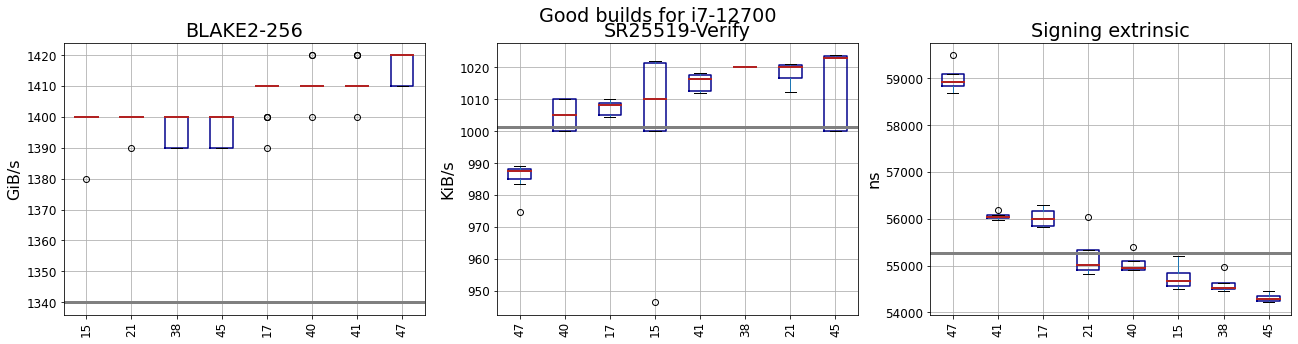

In [18]:
fig, ax = plt.subplots(1,3, figsize=(22, 5))
fig.suptitle("Good builds for i7-12700")
boxplot_sorted(df_sel, by="nb_build", column="BLAKE2-256", ax=ax[0])
ax[0].set_title('BLAKE2-256')
ax[0].set_ylabel('GiB/s')
ax[0].axhline(medians.loc["official"]["BLAKE2-256"],  c='grey', lw=3)
boxplot_sorted(df_sel, by="nb_build", column="SR25519-Verify", ax=ax[1])
ax[1].set_title('SR25519-Verify')
ax[1].set_ylabel('KiB/s')
ax[1].axhline(medians.loc["official"]["SR25519-Verify"],  c='grey', lw=3)
boxplot_sorted(df_ex_sel, by="nb_build", column="Extr-Sign", ax=ax[2], ascending=False)
ax[2].set_title('Signing extrinsic')
ax[2].set_ylabel('ns')
ax[2].axhline(medians.loc["official"]["Extr-Sign"],  c='grey', lw=3)
fig.savefig('images/v0.9.27/pareto_scores_i7_12700.svg', bbox_inches='tight')

In [19]:
build_table[build_table.index.isin(pareto)]

,arch,toolchain,codegen-units,lto,opt-level
nb_build,,,,,
15,alderlake,stable,1,fat,3
17,alderlake,stable,1,thin,3
21,alderlake,stable,16,fat,3
38,alderlake,nightly,1,fat,2
40,alderlake,nightly,1,thin,2
41,alderlake,nightly,1,thin,3
45,alderlake,nightly,16,fat,3
47,alderlake,nightly,16,thin,3


**Interesting**: build 47 is best for BLAKE2 but *very* bad for Signing and Verify. It is even worse then the offical polkadot binary! The optimization options do not predict this bad behavior: ``lto=thin`` and ``codegen-units=16`` is actually recommended. Build 45 switches this to ``lto=fat`` with dramatically better performance!

**What are the winning builds?** 
- Surprisingly, ``opt-level=3`` is not always needed. However, some ``lto`` is required.
- In fact, build 38 (``opt-level=2``) has excellent SR25519-Verify scores with zero variance and very good Signing score.
- Build 45 is best for SR25519-Verify and Signing, and third best for BLAKE2-256. Except for its high variance, build 45 would be a clear winner. It uses ``codegen-units=16``, which is a little surprising.
- Builds 15, 21, 38, and 40 are good mixes between both scores.

Throwing away builds that do not improve the official scores, **we have 15, 21, 38, 40, 45 as the good builds**. It will be interesting to see how it compares on different archs and with the extrinsic timing.

In [20]:
good_builds = ['15', '21', '38', '40', '45'] 

## Summary table of winning builds

Table for the overview page of our website.

In [21]:
# Summary stats with ± mean based on 95% CI
def statistics_table(df, score):
    stats = df.groupby("nb_build")[score].agg(['median', 'mean', 'sem'])
    median_official = stats['median']['official']
    stats['impr med off'] = (stats['median'] - median_official)
    stats['impr med off pct'] = stats['impr med off']/median_official*100
    return stats

In [22]:
stats_score1 = statistics_table(df, 'BLAKE2-256')
stats_score2 = statistics_table(df, 'SR25519-Verify')
stats_score3 = statistics_table(df_ex, 'Extr-Sign')
stats1 = stats_score1.loc[good_builds + ['official', 'docker'], ['median', 'impr med off pct']]
stats1 = stats1.rename(columns={"median": "BLAKE2-256", "impr med off pct": "relative diff (%)"})
stats2 = stats_score2.loc[good_builds + ['official', 'docker'], ['median', 'impr med off pct']]
stats2 = stats2.rename(columns={"median": "SR25519-Verify", "impr med off pct": "relative diff (%)"})
stats3 = stats_score3.loc[good_builds + ['official', 'docker'], ['median', 'impr med off pct']]
stats3 = stats3.rename(columns={"median": "Signing extr", "impr med off pct": "relative diff (%)"})
sum_stats_build = pd.concat([stats1, stats2, stats3], axis=1).round(1)
# print( sum_stats_build.to_markdown() )  # for website
optim_builds = build_table[build_table.index.isin(good_builds)]
pd.concat([sum_stats_build, optim_builds[["codegen-units", "lto", "opt-level"]]], axis=1)

,BLAKE2-256,relative diff (%),SR25519-Verify,relative diff (%),Signing extr,relative diff (%),codegen-units,lto,opt-level
nb_build,,,,,,,,,
15,1400.0,4.5,1010.2,0.9,54660.0,-1.1,1.0,fat,3.0
21,1400.0,4.5,1020.1,1.9,55021.5,-0.5,16.0,fat,3.0
38,1400.0,4.5,1020.0,1.9,54510.5,-1.4,1.0,fat,2.0
40,1410.0,5.2,1005.0,0.4,54947.0,-0.6,1.0,thin,2.0
45,1400.0,4.5,1022.9,2.1,54285.5,-1.8,16.0,fat,3.0
official,1340.0,0.0,1001.4,0.0,55277.5,0.0,NaN,NaN,NaN
docker,1340.0,0.0,1002.6,0.1,55372.0,0.2,NaN,NaN,NaN


Subjectively, we choose best builds 38 and 45.

In [23]:
best_builds = ['38', '45']
build_table[build_table.index.isin(best_builds)]

,arch,toolchain,codegen-units,lto,opt-level
nb_build,,,,,
38,alderlake,nightly,1,fat,2
45,alderlake,nightly,16,fat,3


**This result is somewhat surprising**: ``opt-level=2`` or ``codegen-units=16`` are certainly not the first thing one would try for an optimized build! On the other hand, ``lto=fat`` makes a lot of sense (since it is expensive when building).

## Comparison to v0.9.26

The optimal build on v0.9.26 was 32, which correspondsto our builds 41 (lto=thin) or 37 (lto=off) -- It is not entirely clear what is chosen by cargo. 

In [24]:
builds = ['37', '41'] # good builds from analysis for v0.9.26
stats_score1 = statistics_table(df, 'BLAKE2-256')
stats_score2 = statistics_table(df, 'SR25519-Verify')
stats_score3 = statistics_table(df_ex, 'Extr-Sign')
stats1 = stats_score1.loc[builds + ['official', 'docker'], ['median', 'impr med off pct']]
stats1 = stats1.rename(columns={"median": "BLAKE2-256", "impr med off pct": "relative diff (%)"})
stats2 = stats_score2.loc[builds + ['official', 'docker'], ['median', 'impr med off pct']]
stats2 = stats2.rename(columns={"median": "SR25519-Verify", "impr med off pct": "relative diff (%)"})
stats3 = stats_score3.loc[builds + ['official', 'docker'], ['median', 'impr med off pct']]
stats3 = stats3.rename(columns={"median": "Signing extr", "impr med off pct": "relative diff (%)"})
sum_stats_build = pd.concat([stats1, stats2, stats3], axis=1).round(1)
sum_stats_build

,BLAKE2-256,relative diff (%),SR25519-Verify,relative diff (%),Signing extr,relative diff (%)
nb_build,,,,,,
37,1410.0,5.2,1007.4,0.6,62843.0,13.7
41,1410.0,5.2,1016.3,1.5,56035.5,1.4
official,1340.0,0.0,1001.4,0.0,55277.5,0.0
docker,1340.0,0.0,1002.6,0.1,55372.0,0.2


Quite surprisingly, the Signing scores of these builds are quite bad! (Recall, faster timing is better here so you want a negative difference.) 

**It is therefore important to not only focus on the benchmark scores!**